<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# 读取 intake24 数据
file_path = "/content/drive/MyDrive/UPF-HFI/NOVA classification/outcome/intake24_with_nova.xlsx"
intake_df = pd.read_excel(file_path)


## 检测饮食回忆是否跨日

```
cross_day_records['Starttime_Weekday'] = cross_day_records['Starttime'].dt.weekday
cross_day_records['True_WeekdayType'] = cross_day_records['Starttime_Weekday'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)
```
这段代码并没有依赖 DAY 或 Submissiontime，而是只依赖 Starttime（饮食真正发生的时间）
它的原理就是：

.dt.weekday → 取出 0~6 的星期索引（Monday=0, Sunday=6）
判断 >= 5 → 属于周六/周日 → Weekend
所以你能得到基于真实饮食日的 weekday/weekend 分类



In [3]:
# === 1. 处理时间字段并判断是否跨日 ===
intake_df['Submissiontime'] = pd.to_datetime(intake_df['Submissiontime'], errors='coerce', utc=True)
intake_df['Starttime'] = pd.to_datetime(intake_df['Starttime'], errors='coerce', utc=True)

intake_df['IsPriorDayRecall'] = (
    intake_df['Submissiontime'].dt.normalize() - intake_df['Starttime'].dt.normalize()
).dt.days == 1

# === 2. 导出跨日记录供人工检查 weekday/weekend 判断 ===
cross_day_records = intake_df[intake_df['IsPriorDayRecall'] == True].copy()
cross_day_records['Starttime_Weekday'] = cross_day_records['Starttime'].dt.weekday
cross_day_records['True_WeekdayType'] = cross_day_records['Starttime_Weekday'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

# 简化导出字段供你检查（可调整）
cols_to_export = [
    'UserID_clean', 'DAY', 'Submissiontime', 'Starttime',
    'IsPriorDayRecall', 'True_WeekdayType',
    'Descriptionen', 'Foodgroupen'
]
cross_day_records_export = cross_day_records[cols_to_export].copy()

# 去除时区，避免 Excel 报错
for col in ['Submissiontime', 'Starttime']:
    cross_day_records_export[col] = cross_day_records_export[col].dt.tz_localize(None)

# 保存人工检查文件（你可在这里核对 True_WeekdayType）
cross_day_records_export.to_excel(
    "/content/drive/MyDrive/UPF-HFI/Model/outcome/cross_day_recall_records_for_check.xlsx",
    index=False
)
print("跨日记录已导出，人工检查 True_WeekdayType 是否正确")


跨日记录已导出，人工检查 True_WeekdayType 是否正确


In [5]:
# === 4. 人工检查后，创建修正字段 Revised_DAY 和 Revised_WeekdayType ===
intake_df['Revised_DAY'] = intake_df.apply(
    lambda row: row['Starttime'].strftime('%A') if row['IsPriorDayRecall'] else row['DAY'],
    axis=1
)
intake_df['Revised_WeekdayType'] = intake_df['Revised_DAY'].apply(
    lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday'
)
print("✅ 已完成 Revised_DAY 与 Revised_WeekdayType 创建，可用于加权")

# === 5. 导出用于加权的完整 intake_df 表 ===

# 去除所有 datetime 类型中的 timezone
for col in intake_df.select_dtypes(include='datetimetz').columns:
    intake_df[col] = intake_df[col].dt.tz_localize(None)

# 导出含修正后的字段，保留完整列（推荐直接输出整表便于加权）
intake_df.to_excel(
    "/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_with_revised_weekdaytype.xlsx",
    index=False
)
print("已导出 intake24 总表，含修正 weekday，可直接加权计算")

✅ 已完成 Revised_DAY 与 Revised_WeekdayType 创建，可用于加权
已导出 intake24 总表，含修正 weekday，可直接加权计算


# Weighted average

In [29]:
import pandas as pd

# === Step 0: 读取数据 ===
file_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_with_revised_weekdaytype.xlsx"
df = pd.read_excel(file_path)

# === Step 1: 类型转换 ===
df['Revised_WeekdayType'] = df['Revised_WeekdayType'].astype(str)
df['Energykcal'] = pd.to_numeric(df['Energykcal'], errors='coerce')
df['NOVA'] = pd.to_numeric(df['NOVA'], errors='coerce')

# === Step 2: 计算 weekday/weekend 的总能量 ===
total_kcal = df.groupby(['UserID_clean', 'Revised_WeekdayType'])['Energykcal'].sum().unstack(fill_value=0).reset_index()
total_kcal.rename(columns={'Weekday': 'weekday_kcal', 'Weekend': 'weekend_kcal'}, inplace=True)

# === Step 3: 计算 weekday/weekend 的 UPF 总能量 (NOVA=4) ===
upf_df = df[df['NOVA'] == 4]
upf_kcal = upf_df.groupby(['UserID_clean', 'Revised_WeekdayType'])['Energykcal'].sum().unstack(fill_value=0).reset_index()
upf_kcal.rename(columns={'Weekday': 'weekday_upf_kcal', 'Weekend': 'weekend_upf_kcal'}, inplace=True)

# === Step 4: 合并数据 ===
merged = pd.merge(total_kcal, upf_kcal, on='UserID_clean', how='outer').fillna(0)

# === Step 5: 计算加权总能量和加权 UPF ===
merged['weighted_kcal'] = 5/7 * merged['weekday_kcal'] + 2/7 * merged['weekend_kcal']
merged['weighted_upf_kcal'] = 5/7 * merged['weekday_upf_kcal'] + 2/7 * merged['weekend_upf_kcal']

# === Step 6: 计算 UPF 百分比 ===
merged['weighted_upf_percent'] = (merged['weighted_upf_kcal'] / merged['weighted_kcal']) * 100

# === Step 7: 导出 ===
merged.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx", index=False)
print("weighted_upf_percent 已成功导出！")


weighted_upf_percent 已成功导出！


# 计算每位儿童的 weighted UPF intensity score（加权UPF强度得分）

In [27]:
import pandas as pd

# === Step 0: 导入 intake24 数据 ===
file_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_with_revised_weekdaytype.xlsx"
intake_df = pd.read_excel(file_path)

# 强制转换相关列为数值，防止非数值干扰计算
intake_df["Energykcal"] = pd.to_numeric(intake_df["Energykcal"], errors="coerce")
intake_df["NOVA"] = pd.to_numeric(intake_df["NOVA"], errors="coerce")

# === Step 1: 标记 NOVA 权重 ===
# 你也可以设为 {1:1, 2:2, 3:3, 4:5} 如果要强调UPF（可调节）
nova_weights = {1: 1, 2: 2, 3: 3, 4: 4}
intake_df["UPF_weight"] = intake_df["NOVA"].map(nova_weights)

# === Step 2: 计算每条记录的加权得分 ===
# 如果 Energykcal 或 NOVA 缺失，结果会是 NaN
intake_df["weighted_score"] = intake_df["Energykcal"] * intake_df["UPF_weight"]

# === Step 3: 按 UserID_clean 和 Revised_WeekdayType 分组，计算总能量和得分 ===
agg_df = (
    intake_df
    .groupby(["UserID_clean", "Revised_WeekdayType"])
    .agg(
        total_kcal=("Energykcal", "sum"),
        weighted_kcal=("weighted_score", "sum")
    )
    .reset_index()
)

# === Step 4: 计算每组的 weighted 得分比例 ===
agg_df["score_ratio"] = agg_df["weighted_kcal"] / agg_df["total_kcal"]

# === Step 5: 拆成 weekday 和 weekend 并加权平均 ===
weekday = agg_df[agg_df["Revised_WeekdayType"] == "Weekday"][["UserID_clean", "score_ratio"]].rename(columns={"score_ratio": "weekday_score"})
weekend = agg_df[agg_df["Revised_WeekdayType"] == "Weekend"][["UserID_clean", "score_ratio"]].rename(columns={"score_ratio": "weekend_score"})

# 合并两个子表，填补缺失值为 0
merged = pd.merge(weekday, weekend, on="UserID_clean", how="outer").fillna(0)

# === Step 6: 加权平均合成最终得分（按 5:2 权重）===
merged["weighted_upf_score"] = merged["weekday_score"] * 5/7 + merged["weekend_score"] * 2/7

# === Step 7: 导出结果 ===
output_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_score.xlsx"
merged.to_excel(output_path, index=False)

print("✅ 成功导出 weighted_upf_score.xlsx")


✅ 成功导出 weighted_upf_score.xlsx


# 选出一个对 HFI 敏感、区分度高、解释力强的因变量

In [37]:
# 读取 survey 数据
survey_path = "/content/drive/MyDrive/UPF-HFI/Bradford_original data/4. SurveyMasterfile_clean.xlsx"
survey_df = pd.read_excel(survey_path)

# 定义 HFI 列（根据你截图确认的变量名）
hfi_columns = ['insecurity1', 'insecurity2', 'insecurity3', 'insecurity3a', 'insecurity4', 'insecurity5']

# 打分函数：1, 2 => 记为 1 分，其余（3, 4）为 0 分
def score_response(x):
    return 1 if x in [1, 2] else 0

# 创建 HFI 总得分
survey_df['HFI_score'] = survey_df[hfi_columns].applymap(score_response).sum(axis=1)

# 创建二分类变量（得分 >= 2 为食物不安全）
survey_df['HFI_binary'] = survey_df['HFI_score'].apply(lambda x: 1 if x >= 2 else 0)

# 保留有用列
hfi_df = survey_df[['UserID_clean', 'HFI_score', 'HFI_binary']]

/tmp/ipython-input-432153045.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  survey_df['HFI_score'] = survey_df[hfi_columns].applymap(score_response).sum(axis=1)


In [38]:
# 读取 UPF 数据
upf_percent = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")
upf_score = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_score.xlsx")

# 合并两个 UPF 指标
upf = pd.merge(upf_percent, upf_score, on="UserID_clean", how="inner")

# 合并 HFI 指标
merged = pd.merge(upf, hfi_df, on="UserID_clean", how="inner")


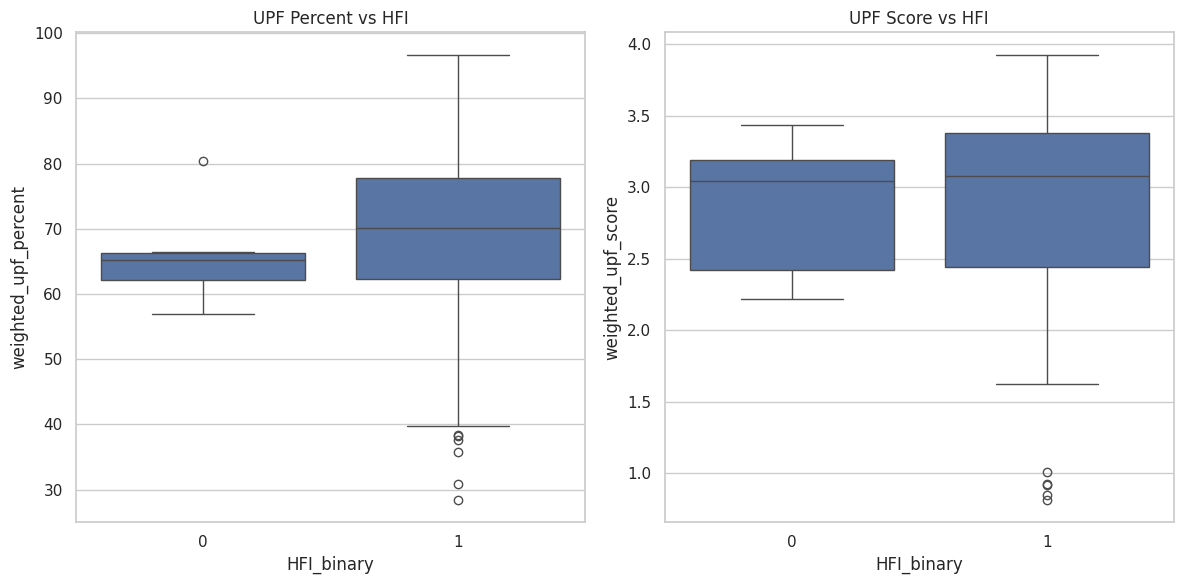

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 百分比箱线图
sns.boxplot(data=merged, x="HFI_binary", y="weighted_upf_percent", ax=axes[0])
axes[0].set_title("UPF Percent vs HFI")

# 强度得分箱线图
sns.boxplot(data=merged, x="HFI_binary", y="weighted_upf_score", ax=axes[1])
axes[1].set_title("UPF Score vs HFI")

plt.tight_layout()
plt.show()


### 可视化结果对比（Boxplot）

我们绘制了 `weighted_upf_percent` 和 `weighted_upf_score` 两个指标在 HFI 二分类变量（HFI_binary）下的分布箱线图，以观察不同食物不安全状况下的 UPF 摄入差异。

- 从图中可以看出，**`weighted_upf_percent` 在 HFI=1 组的中位数明显高于 HFI=0 组**，分布范围也更广，显示出一定的区分能力。
- 而 `weighted_upf_score` 两组之间的中位数差异较小，箱体重叠较多，说明其区分能力相对较弱。
- 这表明：**UPF 能量占比（percent）在不同 HFI 状况下表现出更明显的分布差异，具有更强的可视化解释力。**


# Mann-Whitney 检验

In [40]:
from scipy.stats import mannwhitneyu

# 按 HFI 分组
group0 = merged[merged['HFI_binary'] == 0]
group1 = merged[merged['HFI_binary'] == 1]

# 统计检验
p_percent = mannwhitneyu(group0['weighted_upf_percent'], group1['weighted_upf_percent']).pvalue
p_score = mannwhitneyu(group0['weighted_upf_score'], group1['weighted_upf_score']).pvalue

print(f"UPF 百分比 p值: {p_percent:.4f}")
print(f"UPF 强度得分 p值: {p_score:.4f}")


UPF 百分比 p值: 0.2695
UPF 强度得分 p值: 0.6525


### Mann-Whitney 检验结果

为了定量比较两个 UPF 指标的区分能力，我们使用 Mann-Whitney U 检验比较了 HFI=0 和 HFI=1 两组在每个指标上的差异。结果如下：

- `weighted_upf_percent` 的 p 值为 **0.2695**
- `weighted_upf_score` 的 p 值为 **0.6525**

虽然两个指标在统计上均未达到显著性水平（p > 0.05），但 **`weighted_upf_percent` 的 p 值更低**，说明其在当前样本中对 HFI 具有相对更高的敏感性。

因此，综合可视化和检验结果，我们倾向于选择 **UPF 能量占比（`weighted_upf_percent`）作为主要因变量**，用于后续分析建模。
